In [1]:
# -*- coding:utf-8 -*-

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

In [2]:
%%time

import os

filePath = r'D:\files'

fileMap = {}
size = 0

# 遍历filePath下的文件、文件夹（包括子目录）
for parent, dirnames, filenames in os.walk(filePath):
    for dirname in dirnames:
#         print('parent is %s, dirname is %s' % (parent, dirname))
        pass

    for filename in filenames:
#         print('parent is %s, filename is %s' % (parent, filename))
#         print('the full name of the file is %s' % os.path.join(parent, filename))
        
        size = os.path.getsize(os.path.join(parent, filename))
        fileMap.setdefault(os.path.join(parent, filename), size)

filelist = sorted(fileMap.items(), key=lambda x: x[1], reverse=True)

Wall time: 62.3 ms


In [3]:
for i in filelist:
    col = i[0].split('.')[-2].split('\\')[-1]
    print(col)

bo_srm_xsd
bo_srm_Weight
Brant3406
Brant3408
Brant340A
Brant340D
Brant3203
Brant3306
Brant3308
Brant330A
Brant407A
bo_cis_st
bo_cis_otis
machine2103
machine2105
machine2209
machine2509
machine2799
machine279A
machine279B
Brant2102
Brant2103
Brant2202
Brant2700
Brant2301
Brant2318
Brant4075
sig_status
bo_cis_tfd
Brant406F
Brant3405
Brant340F
Brant3410
machine2104
machine2111
machine2112
machine2113
machine2126
machine2129
machine212B
machine212C
machine212E
machine2204
machine2205
machine2240
machine2301
machine2302
machine2303
machine2388
machine2389
machine2502
machine2510
machine2511
machine2520
machine2521
machine2526
machine2527
machine2529
machine2532
machine2533
machine2549
machine254D
machine2746
machine2747
machine2748
machine2749
machine276E
machine276F
machine2770
machine2771
machine2772
machine2773
machine2774
machine2775
machine2776
machine2777
machine2778
machine2779
machine277A
machine277B
machine277C
machine277D
machine277E
machine277F
machine278D
machine27B1
machine27B2

In [4]:
%%time

def df():
    for filename, size in filelist[:400]:
        reader = pd.read_csv(filename, index_col=False, iterator=True)
        loop = True
        chunkSize = 2000000
        chunks = []
        while loop:
            try:
                chunk = reader.get_chunk(chunkSize)
                chunk = chunk[['Value']]#['2018-07-12 00:00:00':'2018-07-19 00:00:00']
                col = filename.split('.')[-2].split('\\')[-1]
                chunk.rename(columns={'Value':col}, inplace=True)
                chunks.append(chunk)
            except StopIteration:
                loop = False
                print ("Iteration is stopped.")
        df = pd.concat(chunks, ignore_index=True, axis=0)
        yield df

dfs = pd.concat(df(), axis=1)

Iteration is stopped.
Iteration is stopped.
Iteration is stopped.
Iteration is stopped.
Iteration is stopped.
Iteration is stopped.
Iteration is stopped.
Iteration is stopped.
Iteration is stopped.
Iteration is stopped.
Iteration is stopped.
Iteration is stopped.
Iteration is stopped.
Iteration is stopped.
Iteration is stopped.
Iteration is stopped.
Iteration is stopped.
Iteration is stopped.
Iteration is stopped.
Iteration is stopped.
Iteration is stopped.
Iteration is stopped.
Iteration is stopped.
Iteration is stopped.
Iteration is stopped.
Iteration is stopped.
Iteration is stopped.
Iteration is stopped.
Iteration is stopped.
Iteration is stopped.
Iteration is stopped.
Iteration is stopped.
Iteration is stopped.
Iteration is stopped.
Iteration is stopped.
Iteration is stopped.
Iteration is stopped.
Iteration is stopped.
Iteration is stopped.
Iteration is stopped.
Iteration is stopped.
Iteration is stopped.
Iteration is stopped.
Iteration is stopped.
Iteration is stopped.
Iteration 

Iteration is stopped.
Iteration is stopped.
Iteration is stopped.
Iteration is stopped.
Iteration is stopped.
Iteration is stopped.
Iteration is stopped.
Iteration is stopped.
Iteration is stopped.
Iteration is stopped.
Iteration is stopped.
Iteration is stopped.
Iteration is stopped.
Iteration is stopped.
Iteration is stopped.
Iteration is stopped.
Iteration is stopped.
Iteration is stopped.
Iteration is stopped.
Iteration is stopped.
Iteration is stopped.
Iteration is stopped.
Iteration is stopped.
Iteration is stopped.
Iteration is stopped.
Iteration is stopped.
Iteration is stopped.
Wall time: 12min 29s


In [7]:
for filename, size in filelist[:1]:
    reader = pd.read_csv(filename, index_col=False)
    dfs.index = reader['Time']

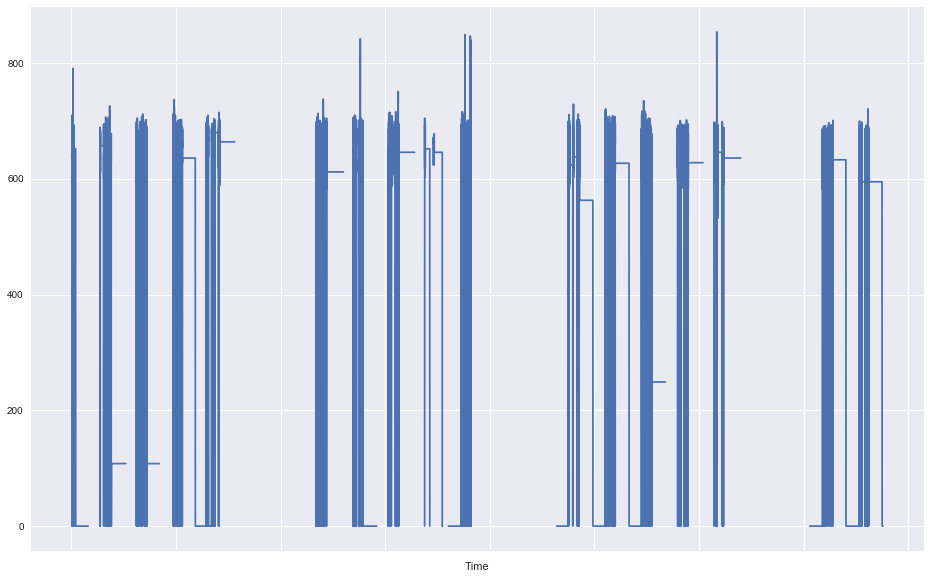

In [8]:
dfs['bo_srm_Weight'][1000000:].plot(figsize=(16,10))

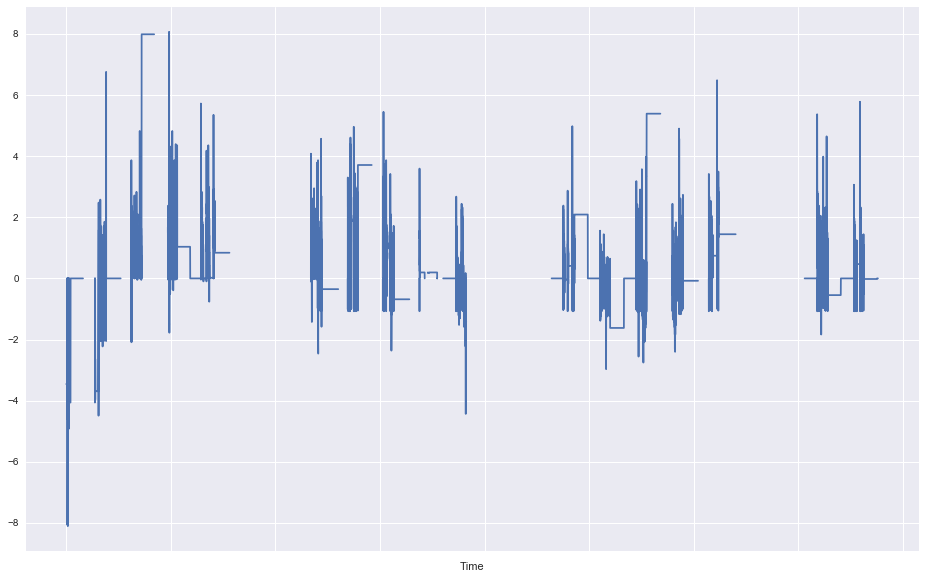

In [9]:
dfs['bo_srm_xsd'][1000000:].plot(figsize=(16,10))

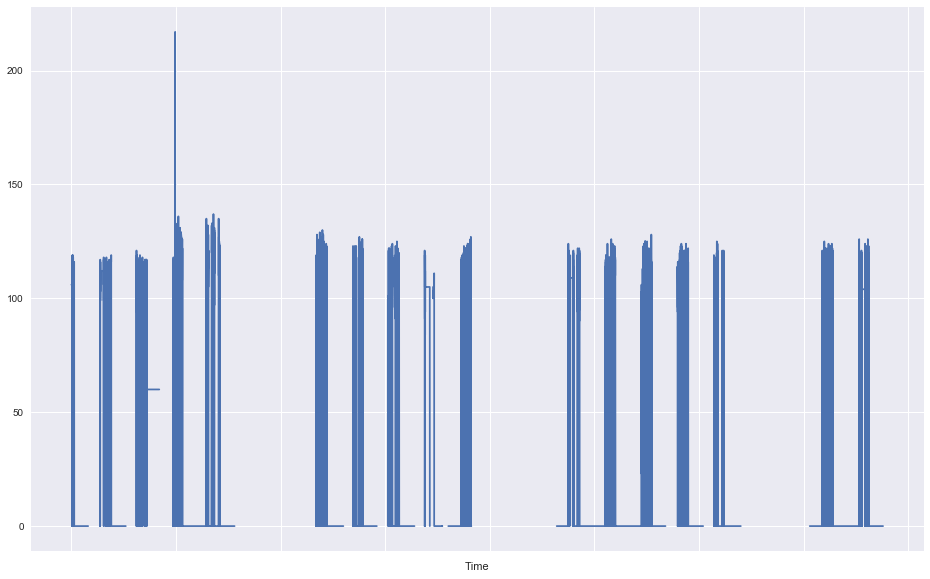

In [10]:
dfs['bo_cis_sz'][1000000:].plot(figsize=(16,10))

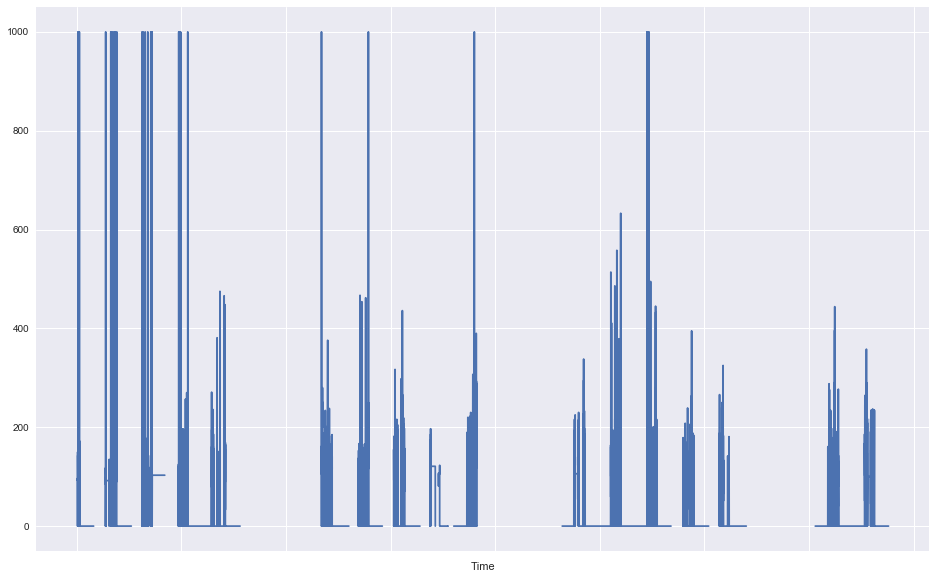

In [11]:
dfs['bo_cis_tfd'][1000000:].plot(figsize=(16,10))

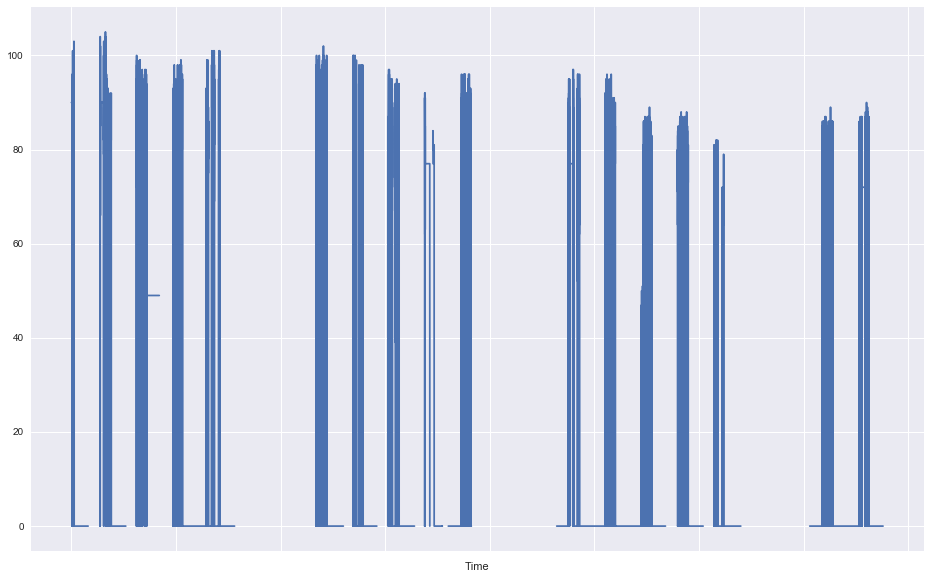

In [12]:
dfs['bo_cis_lq'][1000000:].plot(figsize=(16,10))

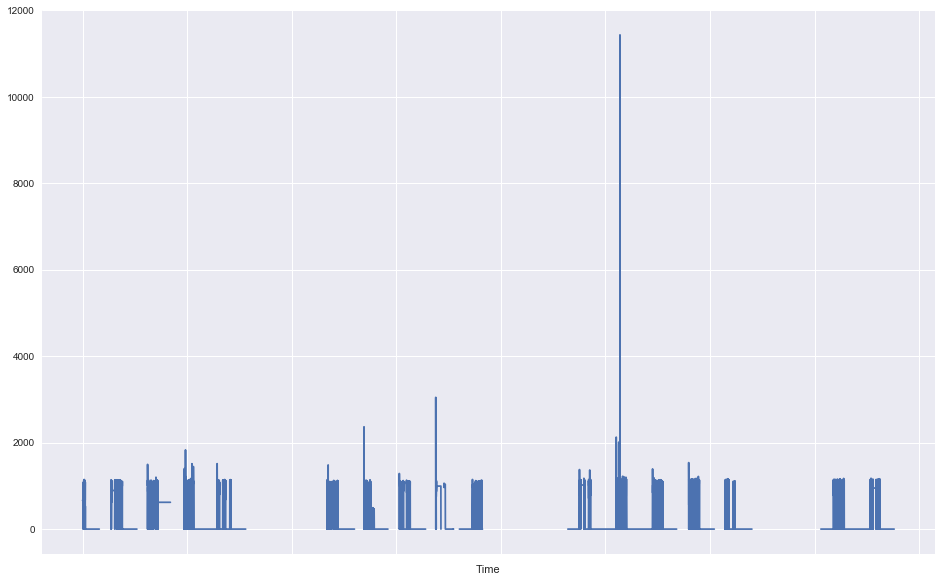

In [13]:
dfs['bo_cis_st'][1000000:].plot(figsize=(16,10))

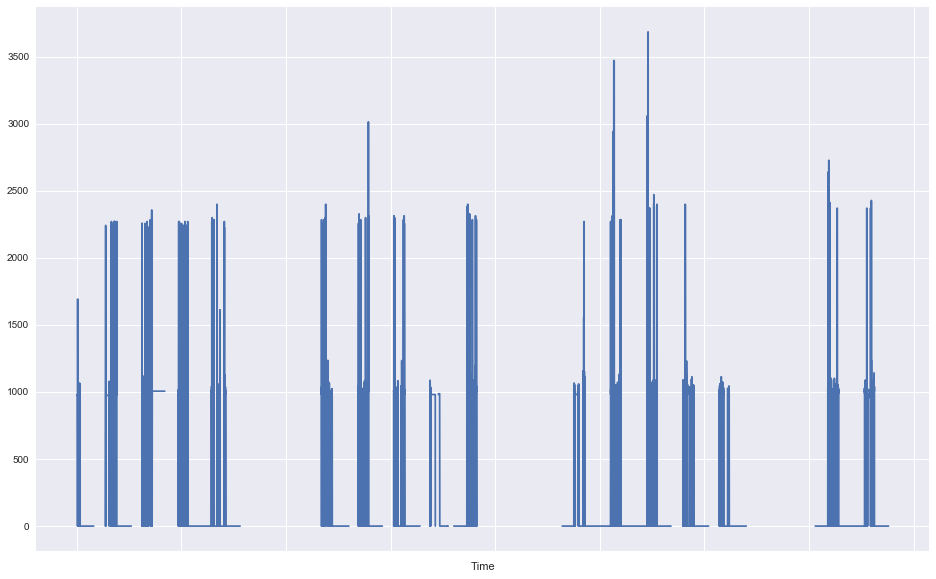

In [14]:
dfs['bo_cis_otis'][1000000:].plot(figsize=(16,10))

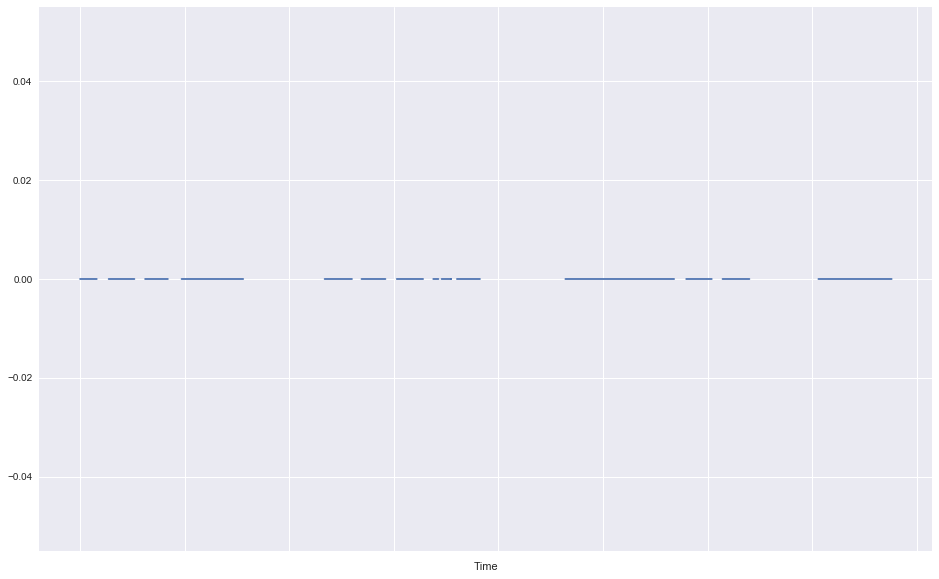

In [15]:
dfs['bo_odim_yz'][1000000:].plot(figsize=(16,10))

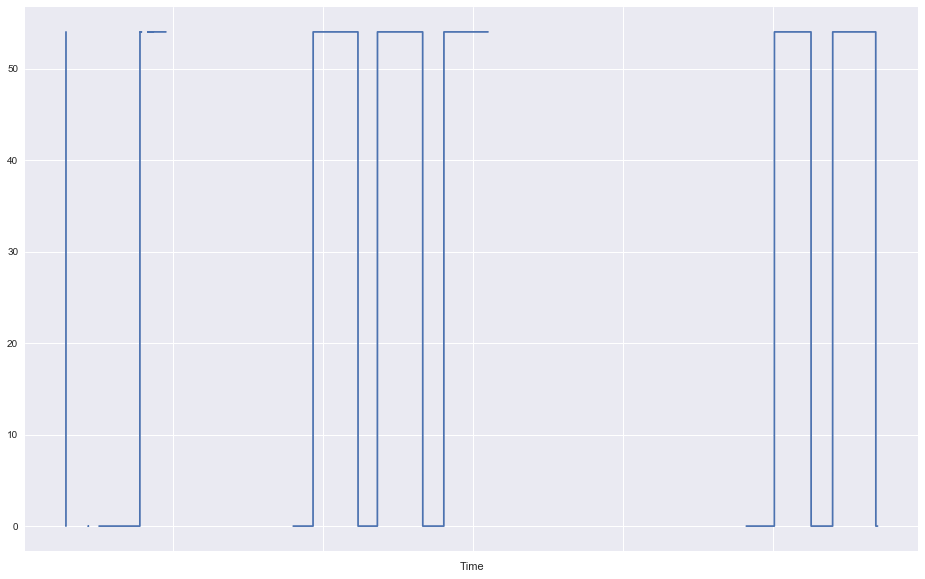

In [16]:
dfs['Brant2100'][1000000:].plot(figsize=(16,10))

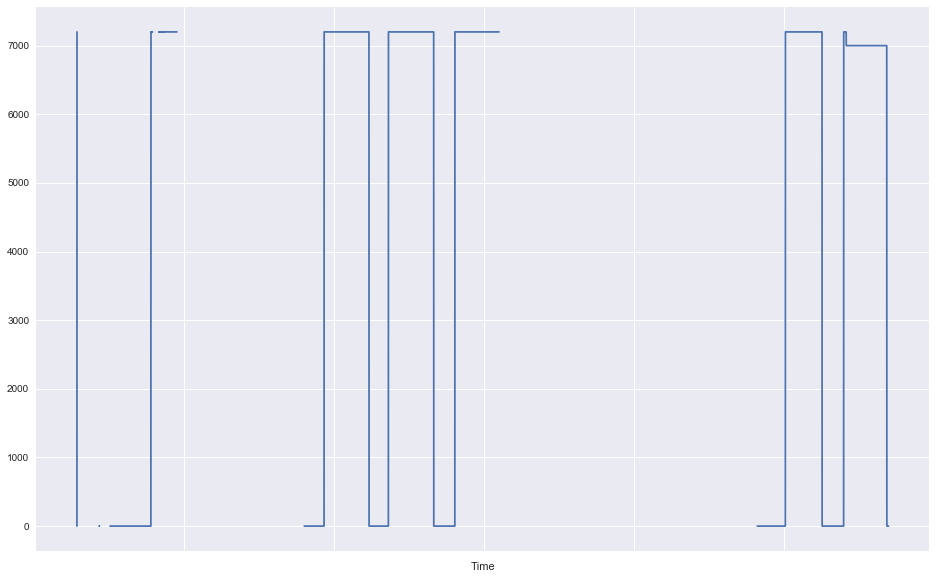

In [17]:
dfs['Brant2102'][1000000:].plot(figsize=(16,10))

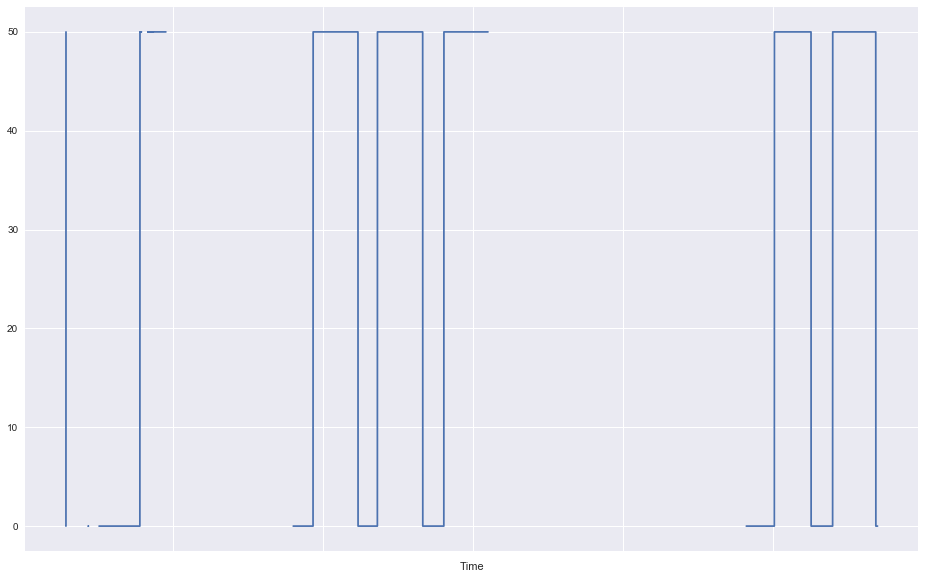

In [18]:
dfs['Brant2201'][1000000:].plot(figsize=(16,10))

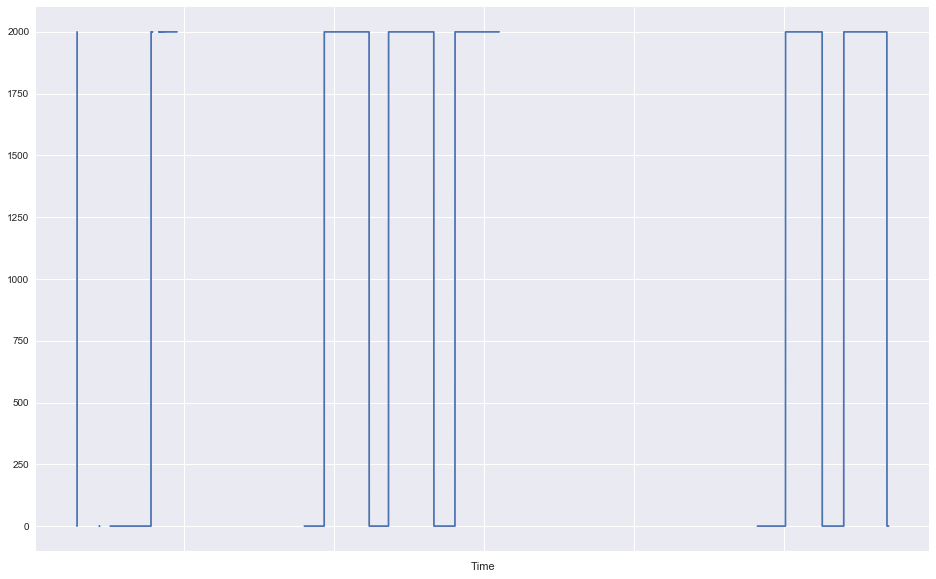

In [19]:
dfs['Brant2202'][1000000:].plot(figsize=(16,10))

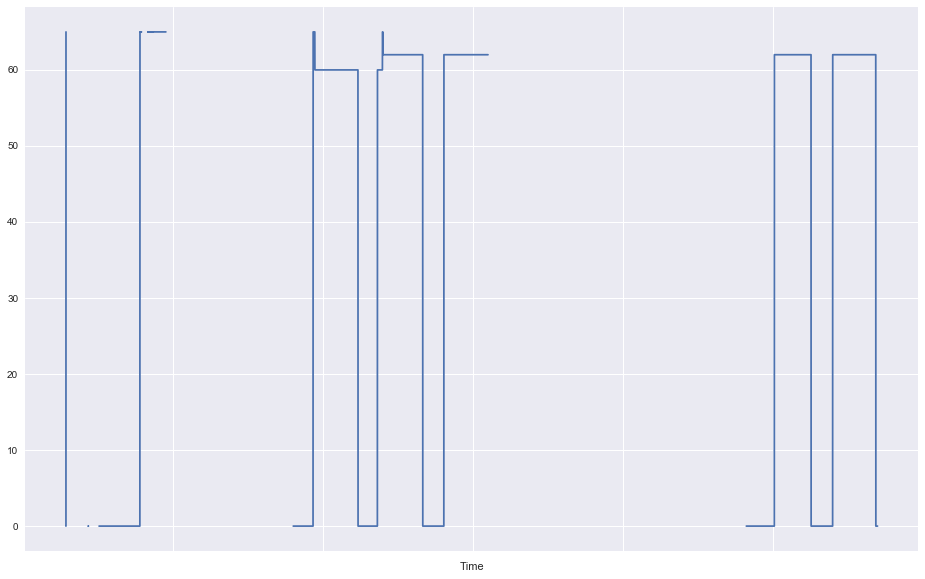

In [20]:
dfs['Brant2203'][1000000:].plot(figsize=(16,10))

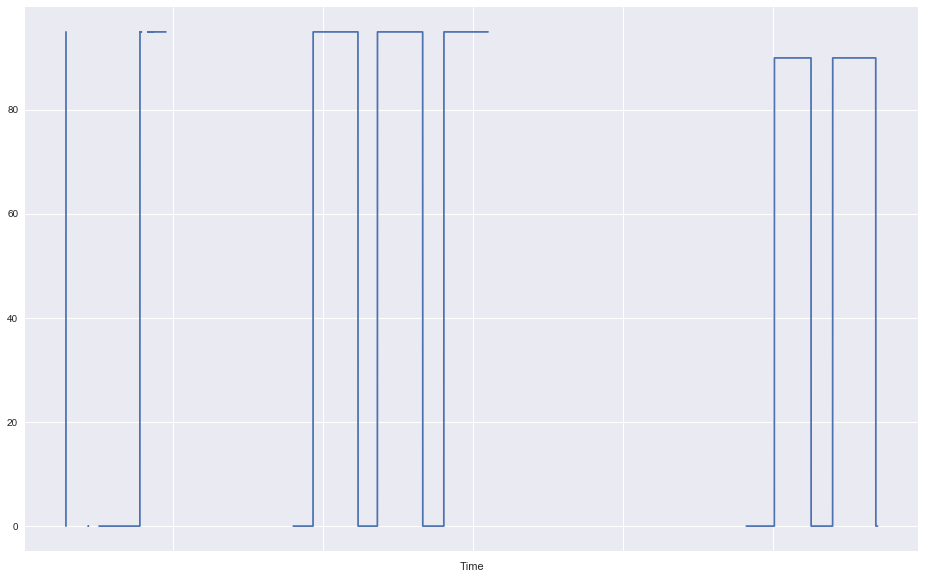

In [21]:
dfs['Brant2208'][1000000:].plot(figsize=(16,10))

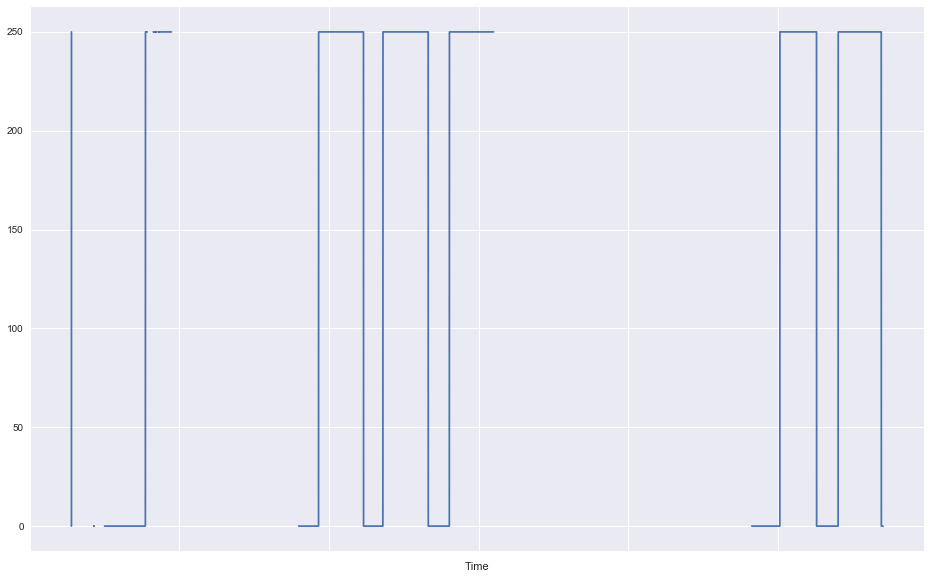

In [22]:
dfs['Brant2309'][1000000:].plot(figsize=(16,10))

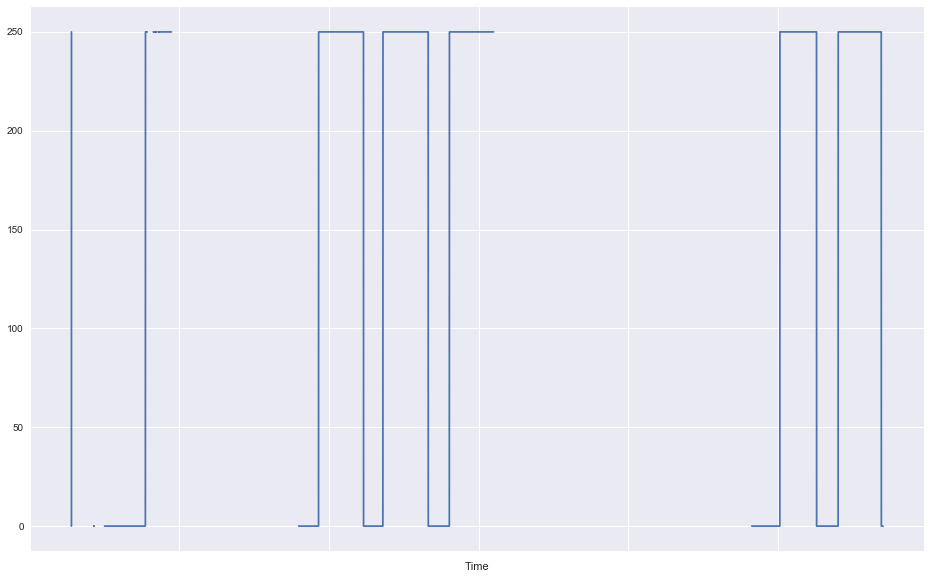

In [23]:
dfs['Brant230A'][1000000:].plot(figsize=(16,10))

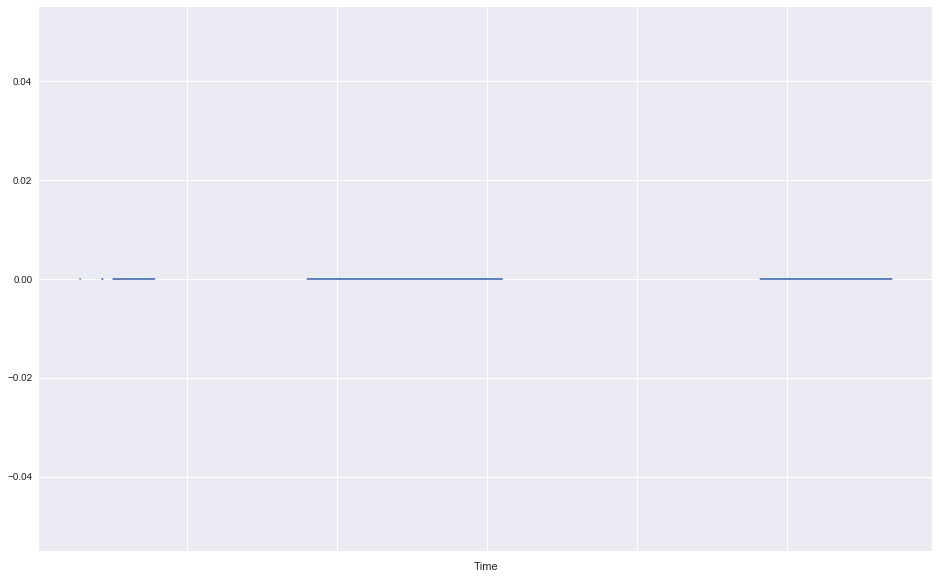

In [24]:
dfs['Brant2320'][1000000:].plot(figsize=(16,10))

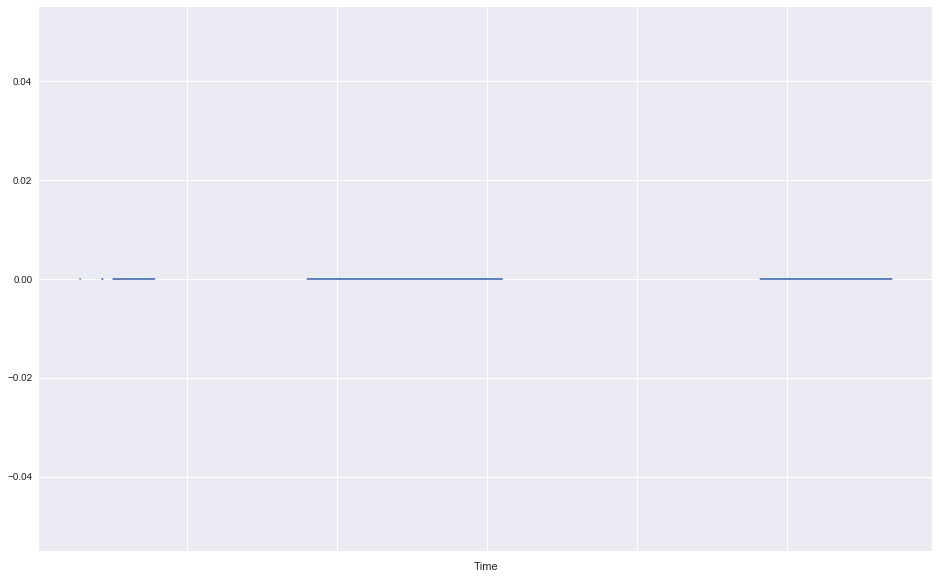

In [25]:
dfs['Brant232A'][1000000:].plot(figsize=(16,10))

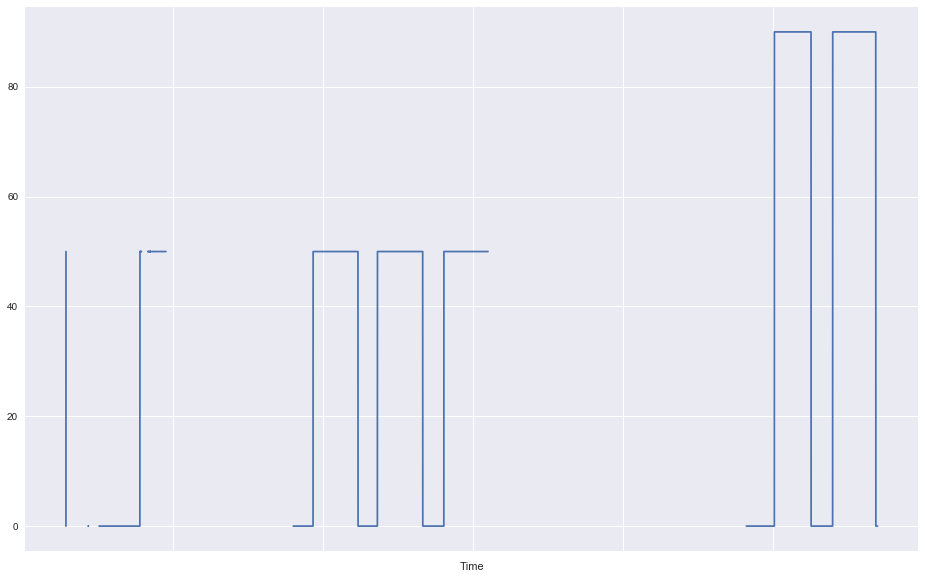

In [26]:
dfs['Brant2502'][1000000:].plot(figsize=(16,10))

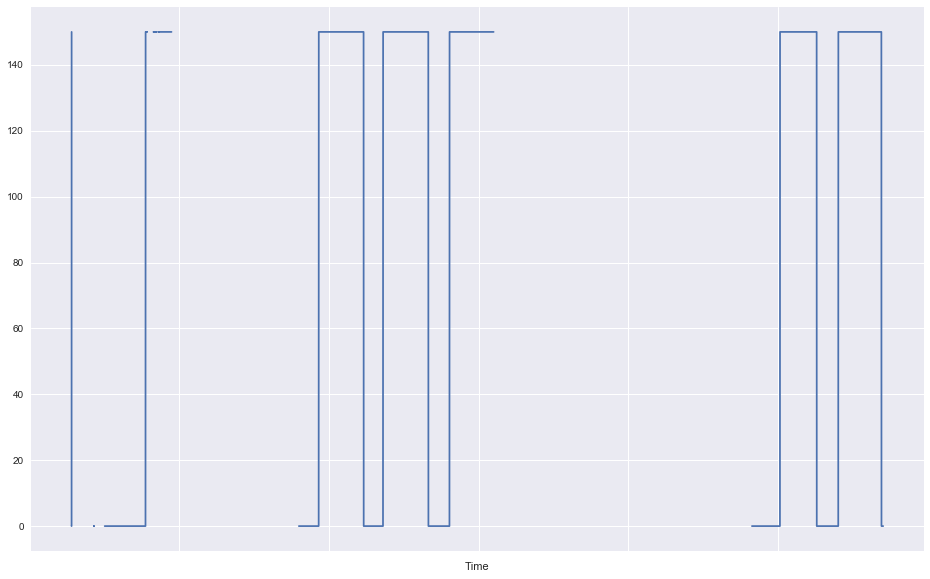

In [27]:
dfs['Brant2503'][1000000:].plot(figsize=(16,10))

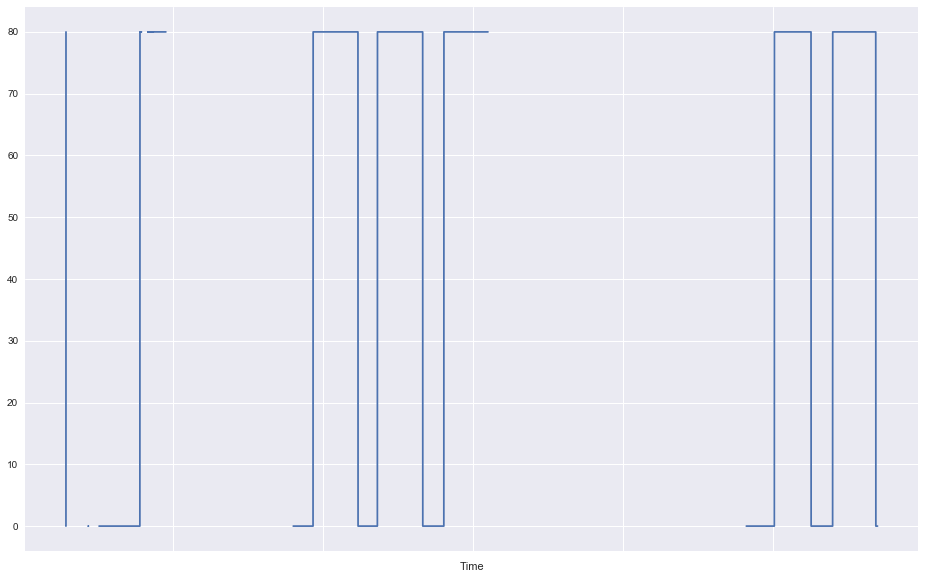

In [28]:
dfs['Brant3102'][1000000:].plot(figsize=(16,10))

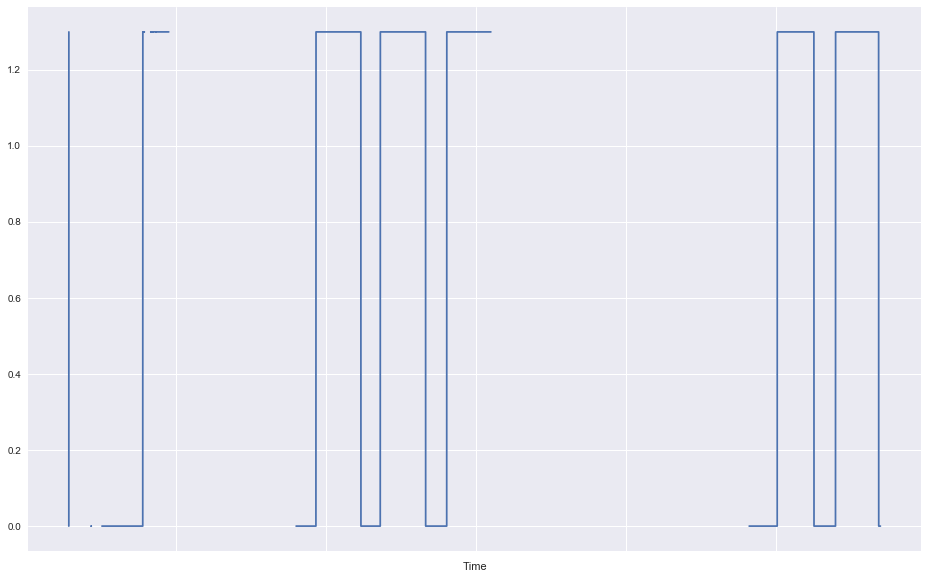

In [29]:
dfs['Brant3103'][1000000:].plot(figsize=(16,10))

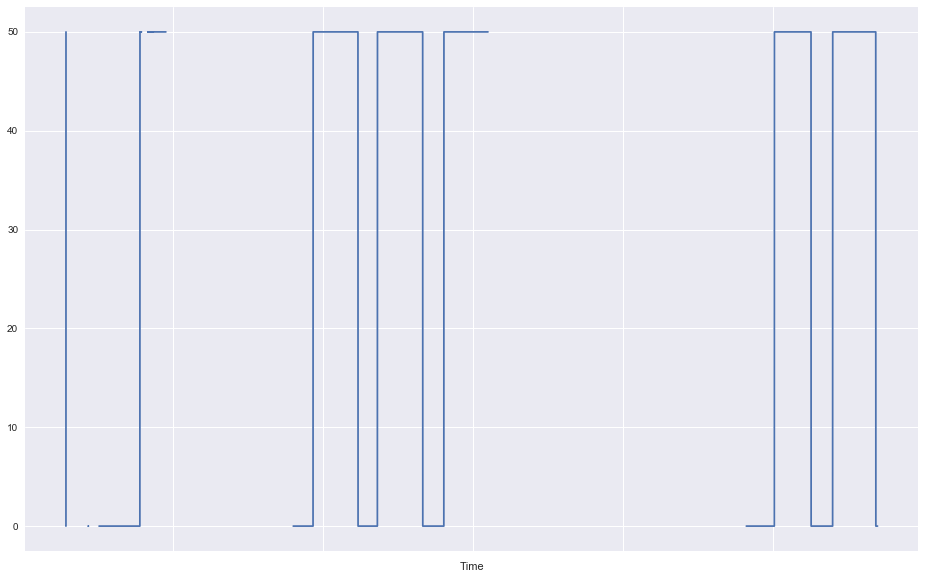

In [30]:
dfs['Brant3202'][1000000:].plot(figsize=(16,10))

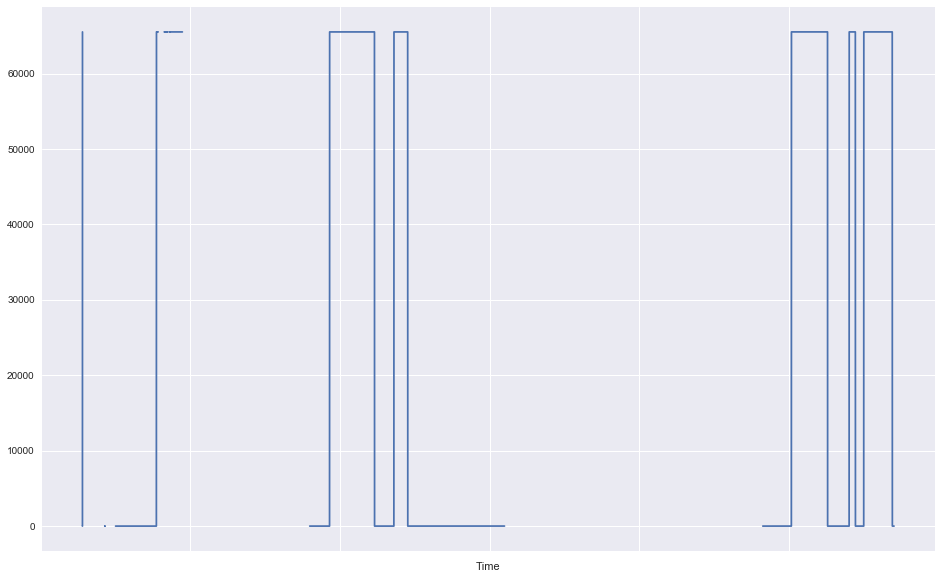

In [31]:
dfs['Brant406F'][1000000:].plot(figsize=(16,10))

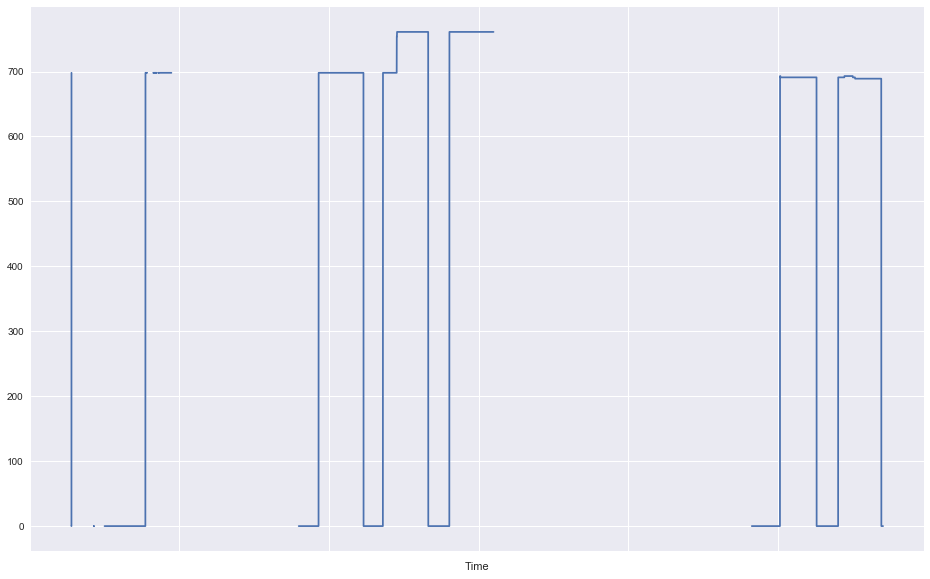

In [32]:
dfs['Brant4071'][1000000:].plot(figsize=(16,10))

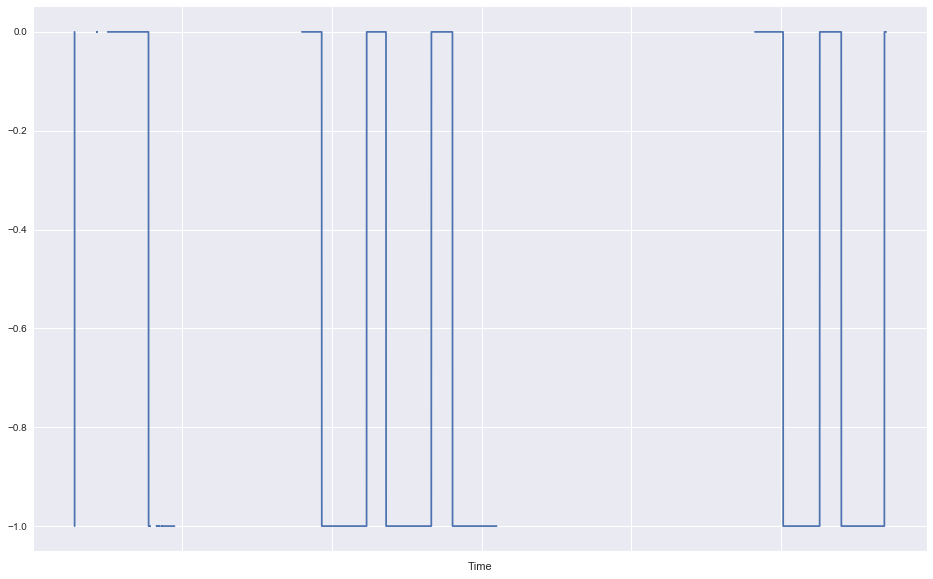

In [33]:
dfs['Brant4083'][1000000:].plot(figsize=(16,10))

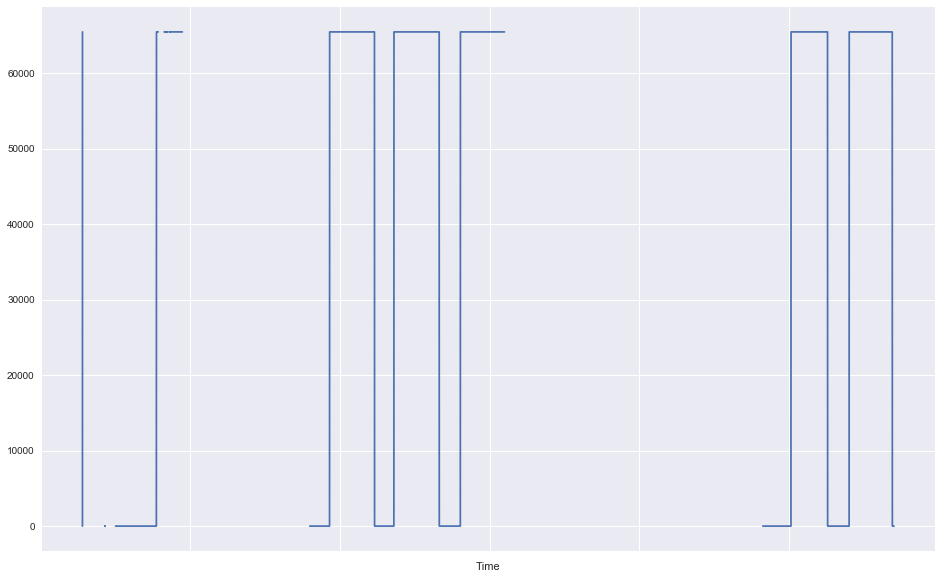

In [34]:
dfs['Brant407A'][1000000:].plot(figsize=(16,10))

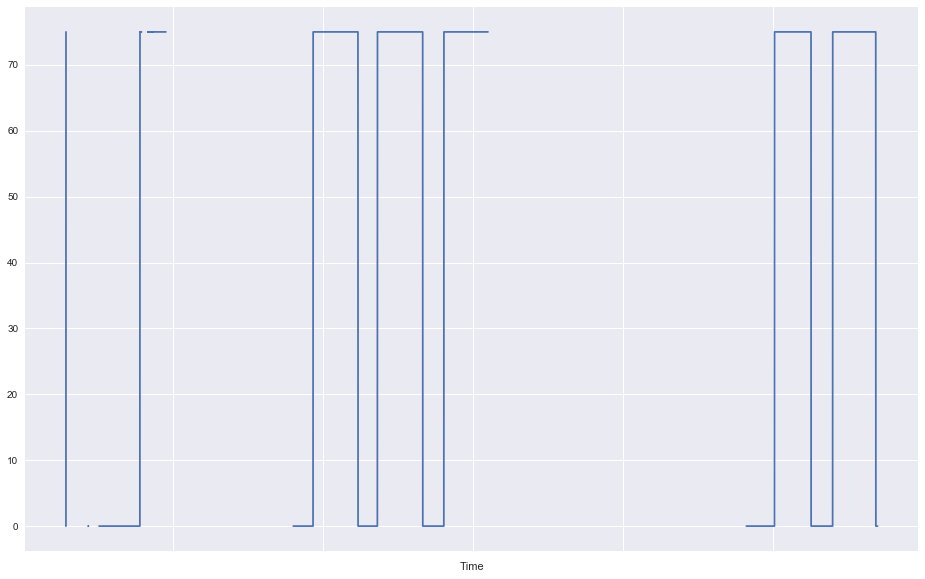

In [35]:
dfs['Brant407B'][1000000:].plot(figsize=(16,10))

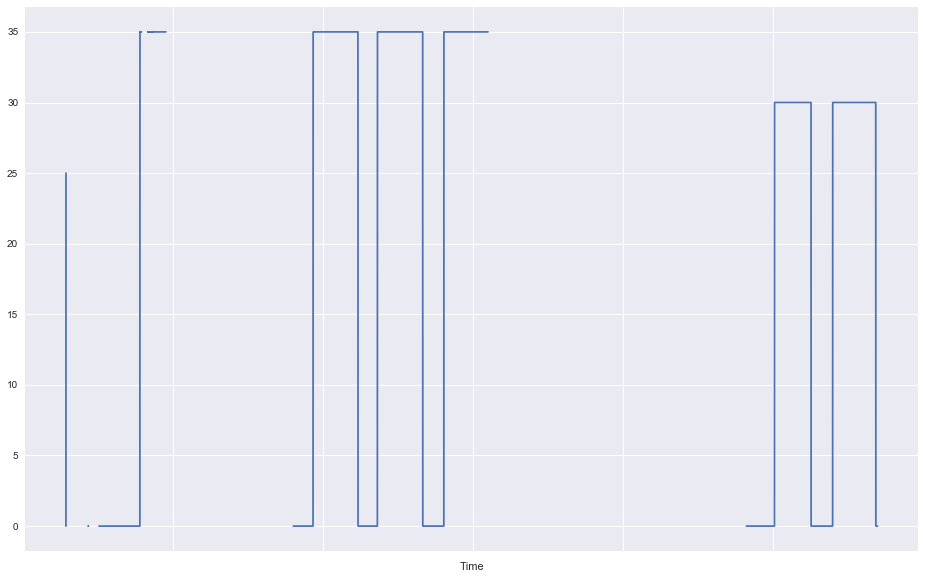

In [36]:
dfs['Brant407C'][1000000:].plot(figsize=(16,10))

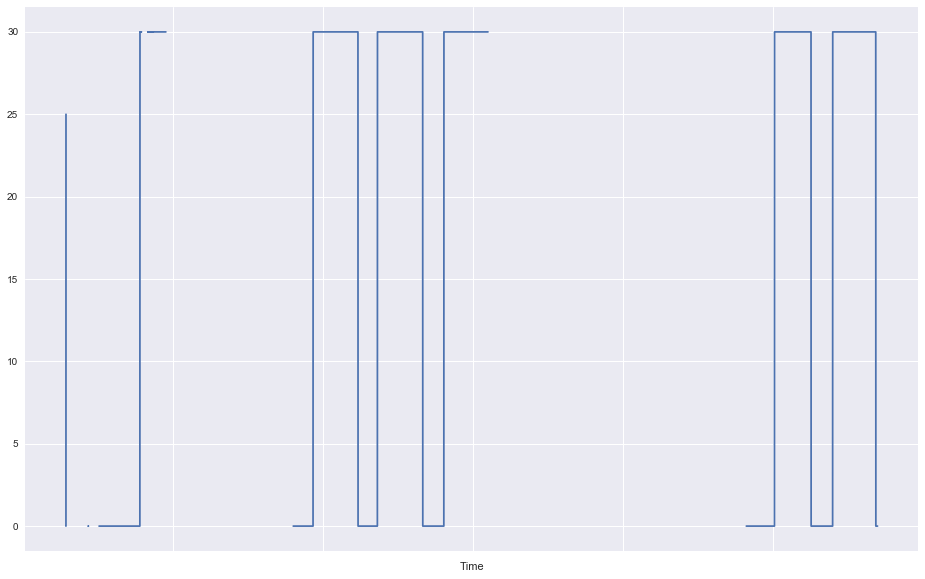

In [37]:
dfs['Brant407D'][1000000:].plot(figsize=(16,10))

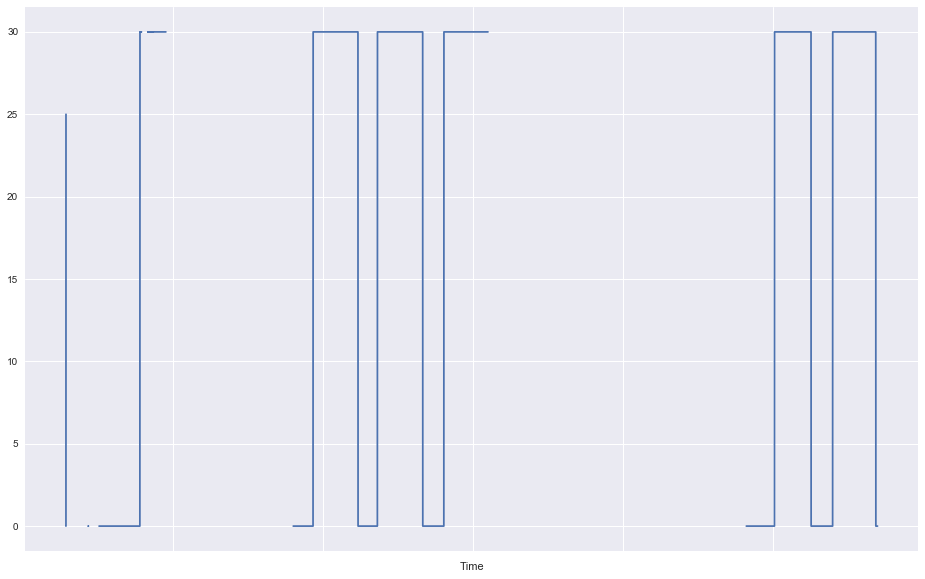

In [38]:
dfs['Brant407E'][1000000:].plot(figsize=(16,10))

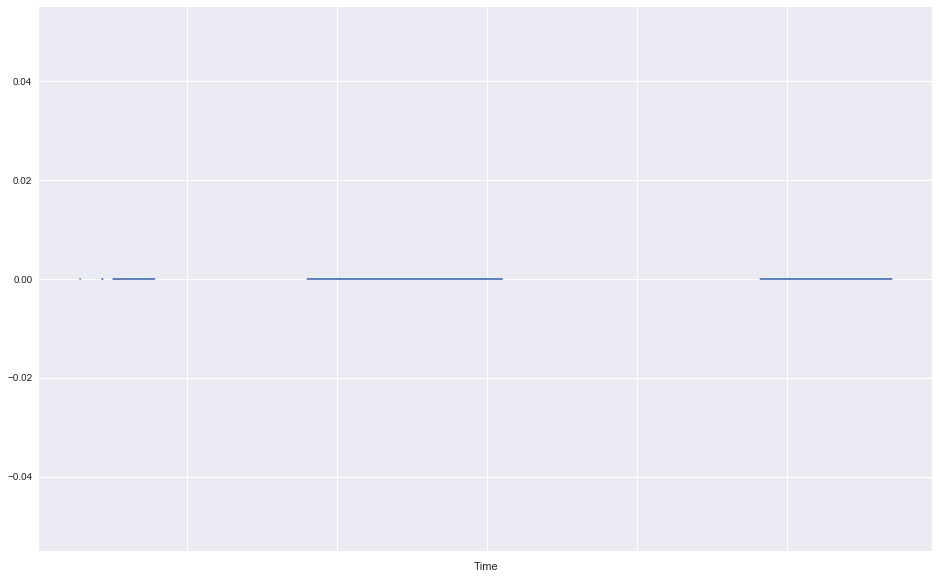

In [39]:
dfs['Brant4002'][1000000:].plot(figsize=(16,10))

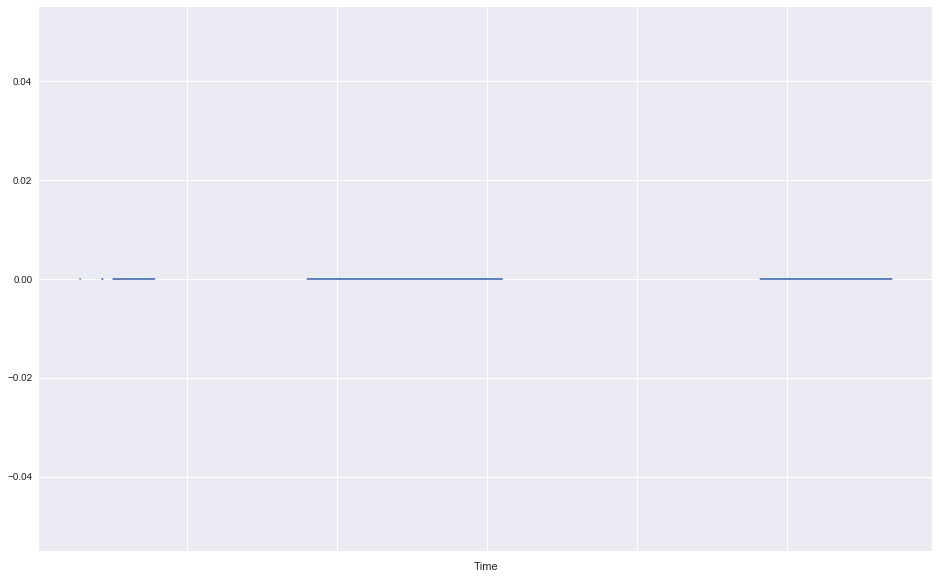

In [40]:
dfs['Brant4003'][1000000:].plot(figsize=(16,10))

In [45]:
# %%time

# dfs.to_csv('dfs.csv')